In [69]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

DATASET_PATH = "dataloader/data/full/SAMPLE_001"
planned_ct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.49998588991250185596277084171475165836.dcm'
cbct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.505160349897793889516650021650971788930.dcm'


planning_ct = sitk.ReadImage(planned_ct_path)[:, :, 0] # drop the last dimension
cbct =  sitk.ReadImage(cbct_path)[:, :, 0] # drop the last dimension

planning_ct_img = sitk.GetArrayFromImage(planning_ct)
cbct_img = sitk.GetArrayFromImage(cbct)

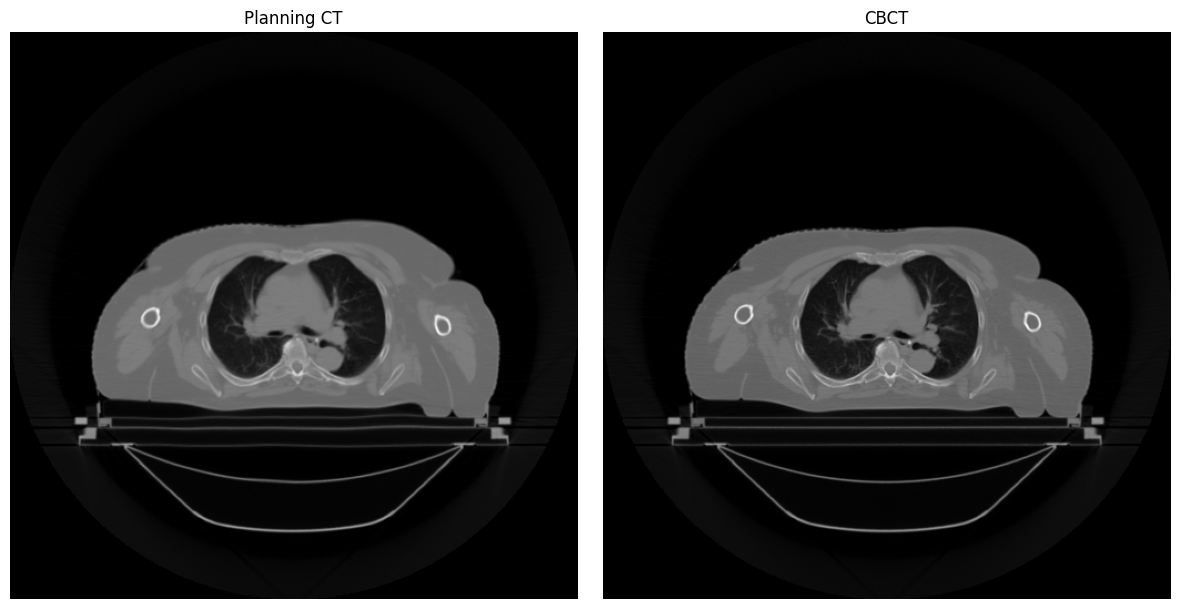

In [72]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(planning_ct_img, cmap='gray')
plt.title('Planning CT')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cbct_img, cmap='gray')
plt.title('CBCT')
plt.axis('off')

plt.tight_layout()
plt.show()

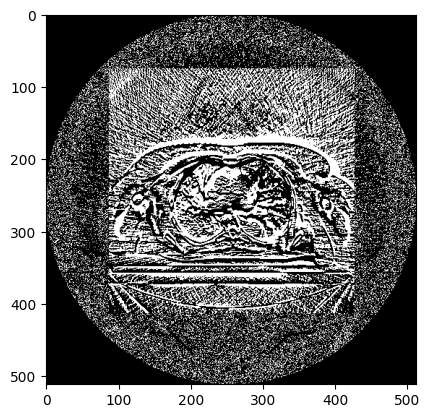

In [63]:
import numpy as np


diff = planning_ct_img - cbct_img
diff[diff < 0] = 0
diff[diff > 0] = 255
plt.imshow(diff, cmap='gray')

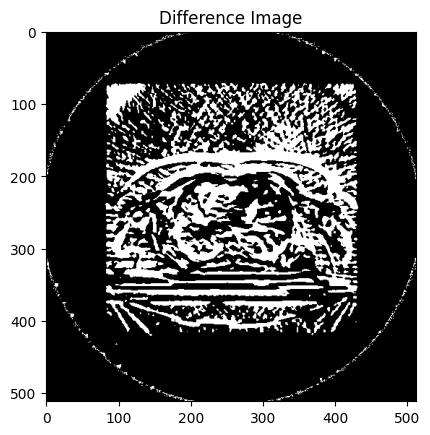

In [118]:
smoothed_planning = sitk.SmoothingRecursiveGaussian(planning_ct, sigma=2.0)
smoothed_cbct = sitk.SmoothingRecursiveGaussian(cbct, sigma=2.0)

def plot_difference(planning_ct, cbct_ct):
    planning_img = sitk.GetArrayFromImage(planning_ct)
    cbct_img = sitk.GetArrayFromImage(cbct_ct)
    diff = planning_img - cbct_img
    diff[diff < 0] = 0
    diff[diff > 0] = 255
    plt.imshow(diff, cmap='gray')
    plt.title('Difference Image')   
    plt.show()
    
def plot_difference(planning_ct, cbct_ct):
    planning_img = sitk.GetArrayFromImage(planning_ct)
    cbct_img = sitk.GetArrayFromImage(cbct_ct)
    diff = planning_img - cbct_img
    diff[diff < 0] = 0
    diff[diff > 0] = 255
    plt.imshow(diff, cmap='gray')
    plt.title('Difference Image')   
    plt.show()
plot_difference(smoothed_planning, smoothed_cbct)
# diff = smoothed_planning_img - smoothed_cbct_img
# diff[diff < 0] = 0
# diff[diff > 0] = 255
# plt.imshow(diff, cmap='gray')
# plt.show()


# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(smoothed_planning_img, cmap='gray')
# plt.title('Planning CT')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(smoothed_cbct_img, cmap='gray')
# plt.title('CBCT')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [78]:
print(smoothed_planning.GetSize())
print(smoothed_cbct.GetSize())

(512, 512)
(512, 512)


In [124]:
def perform_rigid_registration(fixed_image, moving_image):
    registration_method = sitk.ImageRegistrationMethod()
    
    # Use a multi-resolution strategy with image pyramids.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                                                 minStep=1e-4,
                                                                 numberOfIterations=200,
                                                                 gradientMagnitudeTolerance=1e-8)
    
    # Manual check for transform: verify that the initial transform is correctly computed.
    initial_transform = sitk.CenteredTransformInitializer(fixed_image,
                                                          moving_image,
                                                          sitk.Euler2DTransform(),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    final_transform = registration_method.Execute(fixed_image, moving_image)
    return final_transform


# Running registration
transform = perform_rigid_registration(smoothed_planning, smoothed_cbct)


In [127]:
def apply_transform(moving_image, transform, reference_image):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(transform)
    
    resampler.SetOutputDirection(reference_image.GetDirection())
    return resampler.Execute(moving_image)

# Get the fused image
fused_ct = apply_transform(smoothed_cbct, transform, smoothed_planning)
fused_ct = sitk.Flip(fused_ct, [True, True])


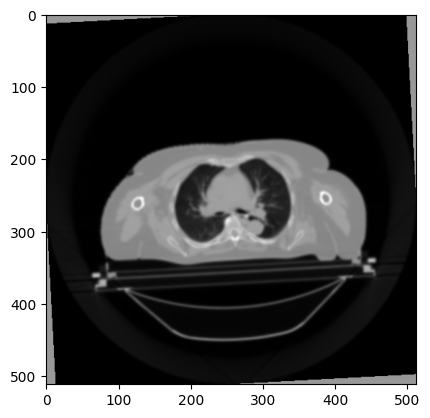

In [128]:
fused_image = sitk.GetArrayFromImage(fused_ct)
plt.imshow(fused_image, cmap='gray')

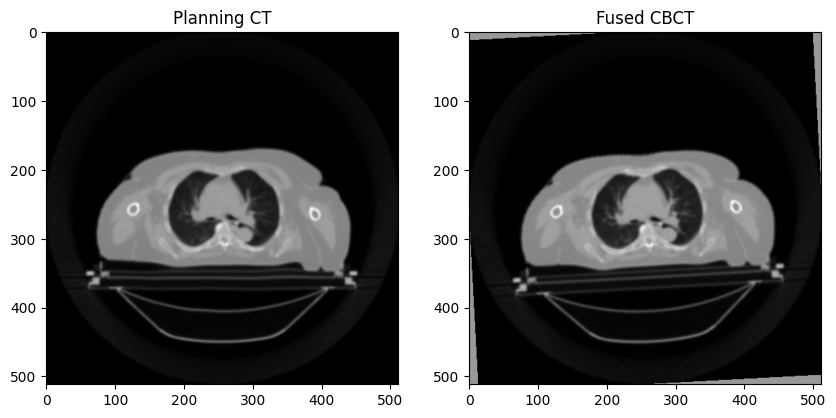

In [129]:
import matplotlib.pyplot as plt
import numpy as np

def display_overlay(fixed, moving, slice_index=50):
    fixed_array = sitk.GetArrayFromImage(fixed)
    moving_array = sitk.GetArrayFromImage(moving)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Planning CT')
    plt.imshow(fixed_array[:, :], cmap='gray')
    
    plt.subplot(1,2,2)
    plt.title('Fused CBCT')
    plt.imshow(moving_array[:, :], cmap='gray')
    plt.show()

display_overlay(smoothed_planning, fused_ct)


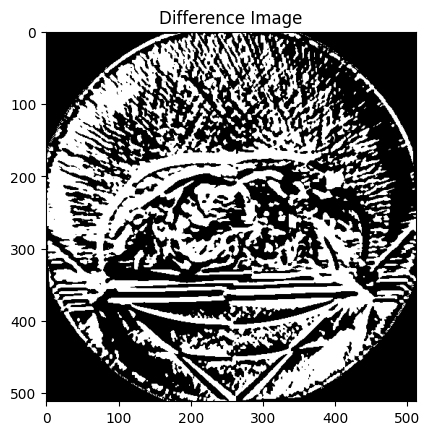

In [130]:
plot_difference(smoothed_planning, fused_ct)